# Imported libraries

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
%matplotlib inline

<h3> Read in the data, store if dataframe

In [86]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

# Tidying up the data

Implementing consistent capitalization and replacing underscores  spaces with hyphens in the data.

In [87]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

<h4> Indexes of the outliers with a bmi above 60 for verification purposes

In [88]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

60.9,64.8,60.2,71.9,78.0,66.8,97.6,63.3,61.2,61.6,64.4,92.0,60.9,

<h4> Cap the outliers at a maximum bmi of 60

In [89]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Preliminary work for binning

In [90]:
##max age of 82, max bin get be set accordingly 
print("The max value in age is : " + str(df['age'].max()))
print("Total number of nulls in age is: " + str(df['age'].isnull().sum())) ##check for null
print("Total number of NAs in age is : " + str(df['age'].isna().sum())) ##check for NAs

The max value in age is : 82.0
Total number of nulls in age is: 0
Total number of NAs in age is : 0


<h2>Unknown_smoking status breakdown

In [91]:
##loop to find the number of unknown smoking entries
unknown_count = 0
##store the indexes of the unknown smoking status entries in case it's needed later
unknown_indexes = []
for index, i in enumerate(df['smoking_status']):
    if(i.lower() == 'unknown'):
        #get index and value 
        #print(index, i)
        unknown_indexes.append(index)
        unknown_count+=1
##get percentage of unknown
unknown_percent = unknown_count/len(df) * 100
unknown_percent = round(unknown_percent,4)
print("\nThe percent of entries with an unknown smoking status is: " + str(unknown_percent) + "% or " +str(unknown_count) + " entries")


The percent of entries with an unknown smoking status is: 30.2153% or 1544 entries


<h2>Checking for non-binary values</h2>
<P>Checked in heart_disease, hypertension, ever_married and stroke. Also converts ever_married to 0/1 instead of yes/no<P>

In [92]:
##check for any non-binary values in heart_disease
non_bin_heart_count = 0
for val in df['heart_disease']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_heart_count == 0):
    print("No non-binary values found in heart_disease")

##check for any non-binary values in hypertension
non_bin_hypt_count = 0
for val in df['hypertension']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_hypt_count == 0):
    print("No non-binary values found in hypertension")
    
##converts ever_married to 0/1 if not already done 
if(isinstance(df['ever_married'][0],str)):
    df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##checks for non-binary values in ever_married
non_bin_married_count = 0
for val in df['ever_married']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_married_count == 0):
    print("No non-binary values found in ever_married")
    
##check for any non-binary values in stroke
non_bin_stroke_count = 0
for val in df['stroke']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_stroke_count == 0):
    print("No non-binary values found in stroke")

No non-binary values found in heart_disease
No non-binary values found in hypertension
No non-binary values found in ever_married
No non-binary values found in stroke


# Impute missing BMI values
<P>Replace missing BMI values with the average BMI found in rows with the same age and gender<P>

In [93]:
##get number of nulls in df
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  218
smoking_status         0
stroke                 0
dtype: int64

In [94]:
df['age'] = df['age'].apply(lambda x : round(x))

m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]


In [81]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<h2>Example of imputed values using the outliers above 60</h2>

In [95]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

32.8,33.5,29.1,32.5,27.9,32.3,28.0,26.2,31.5,31.5,27.9,31.8,31.0,

<h2> Equal-width binning implementation</h2>

In [96]:
##define labels and bins using equal width binning
bins = [0,10,20,30,40,50,60,70,80,90]
labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90']
#replace all age values with their corresponding bin
df['age'] = pd.cut(df['age'], bins=bins,labels=labels)

##print the counts for each bin
age_bins = df.groupby('age')['age'].count().reset_index(name='Count').to_dict(orient='records') ##gets count by bin
print("\nThe sum of people in each age bin is: \n" + str(age_bins))

##get percentage per bin
for d in age_bins:
    for k,v in d.items():
        if(type(v) == int):
            percent = round(v/len(df) * 100,2)
            print("Percentage in bin: " +  str(percent) + "%")


The sum of people in each age bin is: 
[{'age': '0-10', 'Count': 487}, {'age': '10-20', 'Count': 518}, {'age': '20-30', 'Count': 545}, {'age': '30-40', 'Count': 674}, {'age': '40-50', 'Count': 739}, {'age': '50-60', 'Count': 823}, {'age': '60-70', 'Count': 594}, {'age': '70-80', 'Count': 594}, {'age': '80-90', 'Count': 116}]
Percentage in bin: 9.53%
Percentage in bin: 10.14%
Percentage in bin: 10.67%
Percentage in bin: 13.19%
Percentage in bin: 14.46%
Percentage in bin: 16.11%
Percentage in bin: 11.62%
Percentage in bin: 11.62%
Percentage in bin: 2.27%


<h2> Equal-size binning implementation</h2>
    <P>Uncomment if you want to use, will not work if equal-width binning has already been implemented
    if you've already applied equal-width, then read in the data-frame again<P>

In [23]:
'''num_bins = 8
df = pd.read_csv("data//healthcare-dataset-stroke-data.csv")

df['age'] = pd.qcut(df['age'], q = num_bins)
print("total entires in each bin is : ", df['age'].value_counts())
print("\npercentage in each bin is: ", df['age'].value_counts()/len(df)*100)'''

'num_bins = 8\ndf = pd.read_csv("data//healthcare-dataset-stroke-data.csv")\n\ndf[\'age\'] = pd.qcut(df[\'age\'], q = num_bins)\nprint("total entires in each bin is : ", df[\'age\'].value_counts())\nprint("\npercentage in each bin is: ", df[\'age\'].value_counts()/len(df)*100)'

<h1>Some information about outliers</h1>
<P>Any outliers after binning the ages will be found only in BMI (the most extreme outliers have already been dealt with) and avg_glucose_level. Both columns have a large amount of outliers, the exact number and percentages of which can be seen below. We have not yet done anything with these outliers, simply identified them<P>

<h2>Graphing the outliers

<AxesSubplot:xlabel='bmi'>

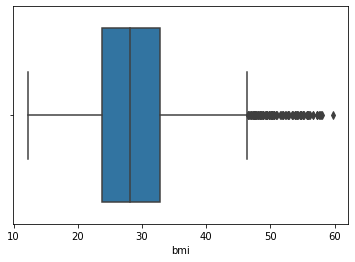

In [99]:
sns.boxplot(x=df['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

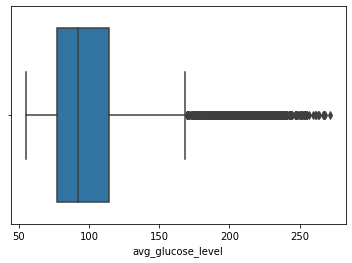

In [98]:
sns.boxplot(x=df['avg_glucose_level'])

<h2>Z-scores to find outliers

<h4>Add in a z-score column to the df

In [136]:
##adds in z-score column to df for bmi and glucose level
cols = ['bmi','avg_glucose_level']
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    
df.head()
##count number of outliers


outliers_bmi_z = np.where((df['bmi_zscore']) >=3)
outliers_glu_z = np.where((df['avg_glucose_level_zscore']) >=3)

outliers_bmi_z = 0
for i in df['bmi_zscore']:
    if(i >=3):
        outliers_bmi_z += 1

outliers_glu_z = 0
for i in df['avg_glucose_level_zscore']:
    if(i >=3):
        outliers_glu_z += 1
        
##get outliers as percentage
z_bmi_percent = outliers_bmi_z/len(df)*100
z_glu_percent = outliers_glu_z/len(df)*100

z_bmi_percent = round(z_bmi_percent,2)
z_glu_percent = round(z_glu_percent,2)

print("number of outliers found with z-score for bmi is : "+ str(outliers_bmi_z) + " which is " +str(z_bmi_percent)+"%")
print("number of outliers found with z-score for bmi is : "+ str(outliers_glu_z) + " which is " +str(z_glu_percent)+"%")

##Uncomment below to get indexes of outliers if needed
#print("Indexes where z-score is greater than 3 for bmi below:\n")
#print(np.where((df['bmi_zscore']) >=3))

#print("\n\nIndexes where z-score is greater than 3 for glucose below:\n")
#print(np.where((df['avg_glucose_level_zscore']) >=3))

number of outliers found with z-score for bmi is : 51 which is 1.0%
number of outliers found with z-score for bmi is : 49 which is 0.96%


<h2>IRQ to find outliers

<h4>Avg_glucose_level

In [130]:
##checking for outliers in avg_glucose_level using iqr
q1_glu = df['avg_glucose_level'].quantile(0.25)
q3_glu = df['avg_glucose_level'].quantile(0.75)
iqr_glu = q3_glu-q1_glu
outliers_glu = (df['avg_glucose_level'] < (q1_glu - 1.5 * iqr_glu)) |(df['avg_glucose_level'] > (q3_glu + 1.5 * iqr_glu))
outliers_glu_count = 0
for i in outliers_glu:
    if(i != False):
        outliers_glu_count += 1
        
iqr_glu_percent = outliers_glu_count/len(df)*100
iqr_glu_percent = round(iqr_glu_percent,2)         
print("number of outliers found with iqr for glucose is : "+ str(outliers_glu_count) + " which is " +str(iqr_glu_percent)+"%")

##uncomment to get the indexes of the outliers if needed
#print("\nIndexes where outliers were detected: ")
#print(np.where(outliers_glu != False))

number of outliers found with iqr for glucose is : 627 which is 12.27%


<h4>BMI

In [131]:
##checking for outliers in bmi using iqr
q1_bmi = df['bmi'].quantile(0.25)
q3_bmi = df['bmi'].quantile(0.75)
iqr_bmi = q3_bmi-q1_bmi
outliers_bmi = (df['bmi'] < (q1_bmi - 1.5 * iqr_bmi)) |(df['bmi'] > (q3_bmi + 1.5 * iqr_bmi))

##count number of outliers
outliers_bmi_count = 0
for i in outliers_bmi:
    if(i != False):
        outliers_bmi_count += 1
        
##get outliers as percentage       
iqr_bmi_percent = outliers_bmi_count/len(df)*100
iqr_bmi_percent = round(iqr_bmi_percent,2) 
print("number of outliers found with iqr for bmi is : "+ str(outliers_bmi_count) + " which is " +str(iqr_bmi_percent)+"%")

##uncomment to get the indexes of the outliers if needed
#print("\nIndexes where outliers were detected: ")
#print(np.where(outliers_bmi != False))

number of outliers found with iqr for bmi is : 110 which is 2.15%
